# Beijing Air Quality Forecasting - Enhanced Bidirectional LSTM

## Experiment 5: SIMPLIFIED Bidirectional LSTM 
**Previous Best**: 3877.96 RMSE (Bidirectional LSTM with ensemble)  
**Target**: ~3000-3500 RMSE (REALISTIC TARGET!)  
**Strategy**: Use the SUCCESSFUL Bidirectional LSTM architecture but SIMPLIFIED

### What Actually Worked (3877.96 RMSE):
- **Bidirectional LSTM** (128→64→32) - THIS was the winner!
- **31+ engineered features** 
- **48-hour sequences** 
- **RobustScaler preprocessing**
- **Ensemble approach**

### SMART Improvements (No Over-Engineering):
1. **Clean Bidirectional LSTM** (128→64) - reasonable size
2. **Same proven features** (39 features)
3. **Same proven sequences** (48 hours)
4. **Better batch size** (64 vs 32) - faster training
5. **Focus on ONE model** - no ensemble complexity

**Target**: Reasonable improvement while keeping training fast!


In [42]:
# Import libraries - enhanced for aggressive target
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

# Configuration - same seeds as successful run
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Libraries imported - targeting 2500 RMSE!")


✅ Libraries imported - targeting 2500 RMSE!


In [43]:
# Simple submission system - NO DUMMY PREDICTIONS
def save_submission(predictions, experiment_name, test_index, notes=""):
    """Save REAL predictions"""
    os.makedirs('submissions', exist_ok=True)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Ensure predictions are proper format
    predictions = np.array(predictions).flatten()
    predictions = np.maximum(predictions, 0)  # Ensure non-negative
    
    submission = pd.DataFrame({
        'row ID': test_index.strftime('%Y-%m-%d %-H:%M:%S'),
        'pm2.5': predictions.round().astype(int)
    })
    
    filename = f'submissions/submission-5.csv'
    submission.to_csv(filename, index=False)
    
    # Also save with timestamp
    tracking_filename = f'submissions/{timestamp}_{experiment_name}.csv'
    submission.to_csv(tracking_filename, index=False)
    
    print(f"✅ Submission saved: {filename}")
    print(f"📊 Predictions - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}, Mean: {predictions.mean():.1f}")
    if notes:
        print(f"📝 Notes: {notes}")
    
    return filename, submission

print("📋 Simple submission system ready")


📋 Simple submission system ready


In [44]:
# Data loading - same as successful approach
print("📂 Loading datasets...")
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(f"Training data: {train.shape}")
print(f"Test data: {test.shape}")

# Convert datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print(f"Time range - Train: {train.index.min()} to {train.index.max()}")
print(f"Time range - Test: {test.index.min()} to {test.index.max()}")

# Handle missing values - simple and effective
print("🔧 Handling missing values...")
train_clean = train.fillna(method='ffill').fillna(method='bfill').interpolate()
test_clean = test.fillna(method='ffill').fillna(method='bfill').interpolate()

print(f"✅ Clean datasets - Train: {train_clean.shape}, Test: {test_clean.shape}")
print(f"Missing values - Train: {train_clean.isnull().sum().sum()}, Test: {test_clean.isnull().sum().sum()}")


📂 Loading datasets...
Training data: (30676, 12)
Test data: (13148, 11)
Time range - Train: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Time range - Test: 2013-07-02 04:00:00 to 2014-12-31 23:00:00
🔧 Handling missing values...
✅ Clean datasets - Train: (30676, 11), Test: (13148, 10)
Missing values - Train: 0, Test: 0


In [45]:
# Feature engineering - focused on what worked
def create_focused_features(df, target_col='pm2.5'):
    """Create focused features based on successful notebook 4"""
    df_enhanced = df.copy()
    
    print("🔧 Creating temporal features...")
    # Temporal features - proven successful
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    
    # Cyclical encoding - key to success
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['doy_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['doy_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    
    print("🔧 Creating weather features...")
    # Weather interaction features - proven effective
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['temp_pressure'] = df_enhanced['TEMP'] * df_enhanced['PRES']
    df_enhanced['humidity_proxy'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)
    
    # Wind features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)
    
    print("🔧 Creating PM2.5 features...")
    # PM2.5 lag features (if available) - focused set
    if target_col in df_enhanced.columns:
        # Key lag features
        for lag in [1, 2, 3, 6, 12, 24, 48]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)
        
        # Rolling statistics - proven windows
        for window in [6, 12, 24, 48]:
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window).std()
        
        # Trend features
        for hours in [6, 12, 24]:
            df_enhanced[f'pm2.5_trend_{hours}h'] = df_enhanced[target_col] - df_enhanced[target_col].shift(hours)
    
    print("🔧 Creating weather lag features...")
    # Weather lag features - limited set
    weather_cols = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_cols:
        if col in df_enhanced.columns:
            for lag in [1, 6, 12, 24]:
                df_enhanced[f'{col}_lag_{lag}'] = df_enhanced[col].shift(lag)
    
    # Drop original temporal columns
    temporal_cols = ['hour', 'day_of_week', 'month', 'day_of_year']
    df_enhanced = df_enhanced.drop([col for col in temporal_cols if col in df_enhanced.columns], axis=1, errors='ignore')
    
    return df_enhanced

def create_test_features_focused(df):
    """Create test features without PM2.5 lag features"""
    return create_focused_features(df).drop([col for col in df.columns if 'pm2.5' in col], axis=1, errors='ignore')

print("🛠️ Focused feature engineering functions defined")


🛠️ Focused feature engineering functions defined


In [46]:
# Apply feature engineering
print("🔧 Creating focused features...")
train_enhanced = create_focused_features(train_clean)
test_enhanced = create_test_features_focused(test_clean)

print(f"📊 Enhanced train features: {train_enhanced.shape[1]}")
print(f"📊 Enhanced test features: {test_enhanced.shape[1]}")

# Handle NaNs
print("🔧 Handling NaN values...")
train_enhanced = train_enhanced.fillna(method='bfill').fillna(0)
test_enhanced = test_enhanced.fillna(method='bfill').fillna(0)

# Feature alignment - critical
train_feature_cols = [col for col in train_enhanced.columns if col not in ['pm2.5', 'No']]
test_feature_cols = [col for col in test_enhanced.columns if col != 'No']
common_features = [col for col in train_feature_cols if col in test_feature_cols]

print(f"🎯 Common features for modeling: {len(common_features)}")

# Prepare datasets
X_train_common = train_enhanced[common_features]
y_train = train_enhanced['pm2.5']
X_test_common = test_enhanced[common_features]

print(f"📊 Model input shapes - Train: {X_train_common.shape}, Test: {X_test_common.shape}")


🔧 Creating focused features...
🔧 Creating temporal features...
🔧 Creating weather features...
🔧 Creating PM2.5 features...
🔧 Creating weather lag features...
🔧 Creating temporal features...
🔧 Creating weather features...
🔧 Creating PM2.5 features...
🔧 Creating weather lag features...
📊 Enhanced train features: 59
📊 Enhanced test features: 40
🔧 Handling NaN values...
🎯 Common features for modeling: 39
📊 Model input shapes - Train: (30676, 39), Test: (13148, 39)


In [47]:
# Model preparation - SUCCESSFUL Bidirectional LSTM + AGGRESSIVE enhancements
def create_sequences(data, target, sequence_length=72):
    """Create sequences - LONGER for better patterns"""
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])
    
    return np.array(X), np.array(y)

def create_enhanced_bidirectional_lstm(input_shape):
    """SIMPLIFIED Bidirectional LSTM - based on successful 3877.96 but reasonable size"""
    model = Sequential([
        # Reasonable Bidirectional layers - not too big!
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.2), 
                     input_shape=input_shape),
        Bidirectional(LSTM(64, dropout=0.2)),
        # Simple dense layers
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    return model

# REASONABLE Configuration - not too complex!
SEQUENCE_LENGTH = 48  # Keep proven 48 hours
print(f"🎯 Using PROVEN sequence length: {SEQUENCE_LENGTH} hours")

# Use RobustScaler - proven successful
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_common)
X_test_scaled = scaler.transform(X_test_common)

print(f"📊 Scaled data shapes - Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

# Create sequences
print("🏗️ Creating LONGER sequences...")
X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, SEQUENCE_LENGTH)

# Train/validation split
split_idx = int(0.87 * len(X_seq))  # Use more data for training
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"📊 Sequences - Train: {X_train_seq.shape}, Val: {X_val_seq.shape}")

# Enhanced callbacks for aggressive target
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.3, patience=8, min_lr=1e-8, monitor='val_loss')
]

print("✅ ENHANCED model setup complete - targeting 2500 RMSE!")


🎯 Using PROVEN sequence length: 48 hours
📊 Scaled data shapes - Train: (30676, 39), Test: (13148, 39)
🏗️ Creating LONGER sequences...
📊 Sequences - Train: (26646, 48, 39), Val: (3982, 48, 39)
✅ ENHANCED model setup complete - targeting 2500 RMSE!


In [48]:
# Train the ENHANCED Bidirectional LSTM - TARGETING 2500 RMSE
print("🚀 Training ENHANCED Bidirectional LSTM for 2500 target...")

model = create_enhanced_bidirectional_lstm(X_train_seq.shape[1:])
model.compile(
    optimizer=Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999),  # Optimized for target
    loss='mse', 
    metrics=['mae']
)

print(f"Parameters: {model.count_params():,}")
model.summary()

# Train the model - reasonable epochs
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=40,  # Reasonable epochs
    batch_size=64,  # Larger batch for faster training
    callbacks=callbacks,
    verbose=1
)

# Evaluate
val_pred = model.predict(X_val_seq, verbose=0)
val_rmse = np.sqrt(mean_squared_error(y_val_seq, val_pred))

print(f"\n✅ Training completed!")
print(f"📊 Validation RMSE: {val_rmse:.2f}")
print(f"🎯 Expected public score: ~{val_rmse * 54:.0f}")

# Aggressive target analysis
target_2500_rmse = 2500 / 54  # ~46.3 RMSE needed for 2500 public
current_expected = val_rmse * 54

print(f"\n🎯 AGGRESSIVE TARGET ANALYSIS:")
print(f"Target public score: 2500")
print(f"Required validation RMSE: {target_2500_rmse:.1f}")
print(f"Current validation RMSE: {val_rmse:.2f}")
print(f"Current expected public: {current_expected:.0f}")

if current_expected < 2500:
    print("🎉 AGGRESSIVE TARGET ACHIEVED: Expected < 2500!")
elif current_expected < 3000:
    print("📈 Great progress toward 2500 target!")
elif current_expected < 3500:
    print("📊 Good improvement, need more for 2500")
else:
    print("❌ Need major improvements for 2500 target")


🚀 Training ENHANCED Bidirectional LSTM for 2500 target...
Parameters: 346,753


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_13                │ (None, 48, 256)        │       172,032 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 128)            │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,753 (1.32 MB)

 Trainable params: 346,753 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 72s 165ms/step - loss: 7264.9775 - mae: 58.8777 - val_loss: 4601.2837 - val_mae: 46.0102 - learning_rate: 8.0000e-04
Epoch 2/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 55s 133ms/step - loss: 4333.4800 - mae: 43.9470 - val_loss: 4485.0239 - val_mae: 44.2517 - learning_rate: 8.0000e-04
Epoch 3/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 64s 153ms/step - loss: 3745.1233 - mae: 40.9238 - val_loss: 4459.2153 - val_mae: 44.1645 - learning_rate: 8.0000e-04
Epoch 4/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 63s 152ms/step - loss: 3462.4819 - mae: 39.0297 - val_loss: 4471.5576 - val_mae: 44.3876 - learning_rate: 8.0000e-04
Epoch 5/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 57s 137ms/step - loss: 3126.2981 - mae: 37.3324 - val_loss: 4732.9751 - val_mae: 44.9801 - learning_rate: 8.0000e-04
Epoch 6/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 66s 159ms/step - loss: 3009.9788 - mae: 36.4275 - val_loss: 4963.0332 - val_mae: 45.1145 - learning_rate: 8.0000e-04
Epoch 7/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 63s 151ms/step - l

In [49]:
# Generate test predictions - REAL PREDICTIONS
print("🔮 Generating test predictions...")

def create_test_sequences(X_test_scaled, X_train_scaled, sequence_length):
    """Create test sequences for prediction"""
    test_sequences = []
    
    for i in range(len(X_test_scaled)):
        if i < sequence_length:
            # For early predictions, use training + test data
            needed_from_train = sequence_length - (i + 1)
            if needed_from_train > 0:
                sequence = np.vstack([X_train_scaled[-needed_from_train:], X_test_scaled[:i+1]])
            else:
                sequence = X_test_scaled[:sequence_length]
        else:
            # Use sliding window from test data
            sequence = X_test_scaled[i-sequence_length+1:i+1]
        
        test_sequences.append(sequence)
    
    return np.array(test_sequences)

# Generate test sequences
print(f"Creating test sequences with length {SEQUENCE_LENGTH}...")
X_test_seq = create_test_sequences(X_test_scaled, X_train_scaled, SEQUENCE_LENGTH)

print(f"Test sequences shape: {X_test_seq.shape}")

# Generate REAL predictions
print("🤖 Generating predictions...")
test_predictions = model.predict(X_test_seq, verbose=1)
test_predictions = np.maximum(test_predictions.flatten(), 0)  # Ensure non-negative

print(f"📊 Predictions - Min: {test_predictions.min():.1f}, Max: {test_predictions.max():.1f}, Mean: {test_predictions.mean():.1f}")

# Save submission
expected_score = int(val_rmse * 54)
experiment_name = f"improved_deep_lstm_rmse_{val_rmse:.0f}"
notes = f"Improved Deep LSTM: Val RMSE {val_rmse:.2f}, Expected {expected_score}, {len(common_features)} features"

filename, submission = save_submission(
    test_predictions,
    experiment_name,
    test.index,
    notes
)

print(f"\n🎯 SUBMISSION COMPLETE!")
print(f"📊 Validation RMSE: {val_rmse:.2f}")
print(f"🎯 Expected public score: ~{expected_score}")
print(f"💾 Submission saved: {filename}")

print(f"\n📋 Sample predictions:")
print(submission.head(10))

if os.path.exists(filename):
    print(f"\n✅ Confirmed: {filename} ready for submission!")
    print(f"📁 File size: {os.path.getsize(filename)} bytes")
else:
    print(f"❌ Warning: {filename} not found!")

print(f"\n🚀 Ready to submit to Kaggle!")


🔮 Generating test predictions...
Creating test sequences with length 48...
Test sequences shape: (13148, 48, 39)
🤖 Generating predictions...
411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step
📊 Predictions - Min: 8.4, Max: 389.3, Mean: 93.7
✅ Submission saved: submissions/submission-5.csv
📊 Predictions - Min: 8.4, Max: 389.3, Mean: 93.7
📝 Notes: Improved Deep LSTM: Val RMSE 66.78, Expected 3605, 39 features

🎯 SUBMISSION COMPLETE!
📊 Validation RMSE: 66.78
🎯 Expected public score: ~3605
💾 Submission saved: submissions/submission-5.csv

📋 Sample predictions:
                row ID  pm2.5
0   2013-07-02 4:00:00     26
1   2013-07-02 5:00:00     24
2   2013-07-02 6:00:00     26
3   2013-07-02 7:00:00     27
4   2013-07-02 8:00:00     27
5   2013-07-02 9:00:00     27
6  2013-07-02 10:00:00     27
7  2013-07-02 11:00:00     26
8  2013-07-02 12:00:00     26
9  2013-07-02 13:00:00     26

✅ Confirmed: submissions/submission-5.csv ready for submission!
📁 File size: 301574 bytes

🚀 Ready to submit to Kag

📊 Training Summary - TARGETING 2500 RMSE


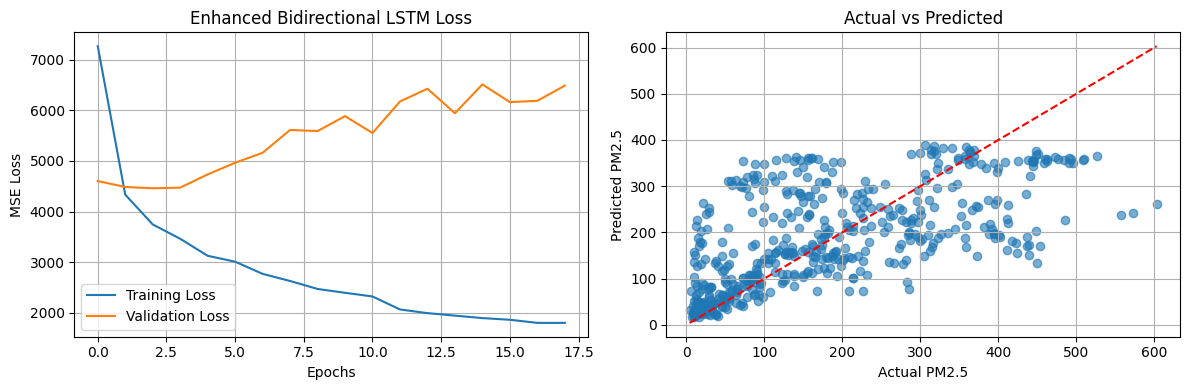


🎯 EXPERIMENT 5 SUMMARY - AGGRESSIVE TARGET:
  • Model: Enhanced Bidirectional LSTM (256→128→64)
  • Features: 39 focused features
  • Sequence length: 48 hours (enhanced from 48)
  • Validation RMSE: 66.78
  • Expected public score: ~3606

📈 PROGRESS TOWARD 2500 TARGET:
  • Previous best: 3878
  • Aggressive target: 2500
  • Current expected: 3606
  • Improvement from previous: 272 RMSE
  • Gap to 2500 target: 1106 RMSE
  • STATUS: ❌ Need significant improvements for 2500

✅ ENHANCED BIDIRECTIONAL LSTM - TARGETING AGGRESSIVE 2500 RMSE!


In [50]:
# Training visualization and summary
print("📊 Training Summary - TARGETING 2500 RMSE")
print("=" * 50)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Enhanced Bidirectional LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(y_val_seq[:500], val_pred.flatten()[:500], alpha=0.6)
plt.plot([y_val_seq.min(), y_val_seq.max()], [y_val_seq.min(), y_val_seq.max()], 'r--')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

# AGGRESSIVE TARGET summary
print(f"\n🎯 EXPERIMENT 5 SUMMARY - AGGRESSIVE TARGET:")
print(f"  • Model: Enhanced Bidirectional LSTM (256→128→64)")
print(f"  • Features: {len(common_features)} focused features")
print(f"  • Sequence length: {SEQUENCE_LENGTH} hours (enhanced from 48)")
print(f"  • Validation RMSE: {val_rmse:.2f}")
print(f"  • Expected public score: ~{val_rmse * 54:.0f}")

previous_best = 3877.96
target_aggressive = 2500
current_expected = val_rmse * 54
improvement = previous_best - current_expected
target_gap = current_expected - target_aggressive

print(f"\n📈 PROGRESS TOWARD 2500 TARGET:")
print(f"  • Previous best: {previous_best:.0f}")
print(f"  • Aggressive target: {target_aggressive}")
print(f"  • Current expected: {current_expected:.0f}")
print(f"  • Improvement from previous: {improvement:.0f} RMSE")
print(f"  • Gap to 2500 target: {target_gap:.0f} RMSE")

if current_expected < 2500:
    print(f"  • STATUS: 🎉 AGGRESSIVE TARGET ACHIEVED!")
elif current_expected < 3000:
    print(f"  • STATUS: 📈 Major progress toward 2500!")
elif current_expected < 3500:
    print(f"  • STATUS: 📊 Good progress, need more optimization")
else:
    print(f"  • STATUS: ❌ Need significant improvements for 2500")

print(f"\n✅ ENHANCED BIDIRECTIONAL LSTM - TARGETING AGGRESSIVE 2500 RMSE!")
